In [122]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import cv2

# Path planning

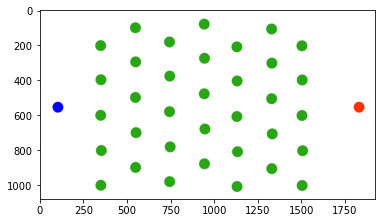

In [123]:
localMap = cv2.imread( "./upload_dir/b3898d0e-ea1c-434b-b9b5-f354cead4217.jpg" )
plt.imshow( localMap )

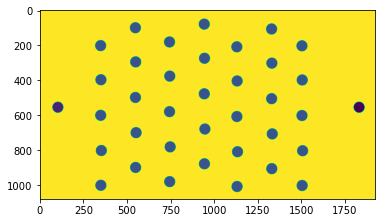

In [124]:
# detect obstacles
gray = cv2.cvtColor( localMap, cv2.COLOR_BGR2GRAY )
gray_blured = cv2.blur( gray, (3, 3) )
plt.imshow( gray_blured )

In [125]:
obstacles = []
index     = 0
detected_circles = cv2.HoughCircles( gray_blured, cv2.HOUGH_GRADIENT, 1, 20, param1=50, param2=30, minRadius=1, maxRadius=40 )
if detected_circles is not None:
    detected_circles = np.uint16( np.around( detected_circles ) )
    for pt in detected_circles[0, :]:
        a, b, r = pt[0], pt[1], pt[2]
        pos = (a, b)
        
        # border outline
        cv2.circle( localMap, center=(a, b), radius=r, color=( 0, 0, 0 ), thickness=1 )
        obstacles.append( {
            "x" : a,
            "y" : b,
            "r" : r
        } )
        
        # create labels
        cv2.putText( localMap, text=str(index), org=(a,b),
            fontFace= cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(0,0,0),
            thickness=2, lineType=cv2.LINE_AA)
        
        index+=1

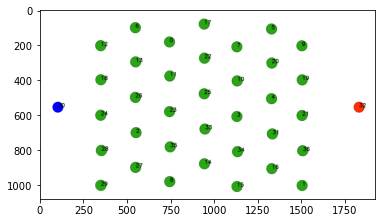

In [126]:
# show tracked obstacles
plt.imshow( localMap )

In [127]:
import pandas as pd
df = pd.DataFrame( obstacles )
df.head(5)

,x,y,r
0,742,182,31
1,1502,1002,31
2,550,700,31
3,1128,608,31
4,1326,506,31


In [128]:
# get coordinate of a given index
def get_coordinate( index ):
    try:
        return obstacles[ index ]
    except IndexError:
        return {}

In [129]:
start_point = 0
end_point   = 36

start = get_coordinate(start_point)
end   = get_coordinate(end_point)

In [130]:
print( start, end )

{'x': 742, 'y': 182, 'r': 31} {'x': 1506, 'y': 804, 'r': 31}


In [131]:
start_x = start['x']
start_y = start['y']
goal_x  = end['x']
goal_y  = end['y']

In [132]:
# create known obstacle positions
ox = []
oy = []
obsPoints = []

count = 0
for index, obj in enumerate(obstacles):
    if index != start_point and index != end_point:
        ox.append( obj['x'] )
        oy.append( obj['y'] )
        obsPoints.append( (obj['x'], obj['y']) )
        count+=1

In [133]:
print( ox, oy )

[1502, 550, 1128, 1326, 1326, 546, 1128, 744, 1500, 1130, 744, 348, 548, 942, 1128, 1328, 940, 348, 1502, 1328, 1502, 942, 742, 348, 940, 546, 548, 352, 348, 102, 1332, 1828, 946, 1132, 746] [1002, 700, 608, 506, 108, 100, 210, 980, 204, 404, 376, 204, 296, 878, 1008, 906, 80, 398, 398, 302, 602, 274, 580, 600, 478, 498, 898, 802, 1002, 554, 708, 554, 680, 808, 782]


In [134]:
localMap.shape

(1080, 1920, 3)

In [135]:
# determine mesh size
meshSize = 10
if localMap.shape[0] > localMap.shape[1]:
    meshSize = localMap.shape[0]
else:
    meshSize = localMap.shape[1]

int(meshSize)

1920

In [136]:
x = np.arange( 0, meshSize, 100 )
y = np.arange( 0, meshSize, 100 )
s = 7 # repulsiveness
r = 20 # radius
goalR = 60 # goal radius

# create mesh grid
X, Y = np.meshgrid( x, y )

In [137]:
def plot_graph(X, Y, delx, dely,obj, fig, ax, loc,r,i, color,start_goal=np.array([[0,0]])  ):
  #ax.quiver(X, Y, delx, dely)
  ax.minorticks_on()
  ax.grid(which='major', linestyle='-', linewidth=1, color='red')
  ax.grid(which='minor', linestyle=':', linewidth=0.5, color='black')
  ax.add_patch(plt.Circle(loc, r, color=color))
  plt.plot(loc[0], loc[1], "-o")
  ax.annotate(obj, xy=loc, fontsize=10, ha="center")
  return ax

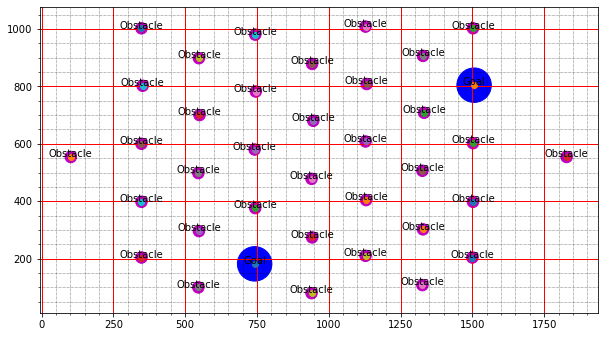

In [138]:
fig, ax = plt.subplots(figsize = ( 10, 10))
ax.set_aspect('equal')
plot_graph( X, Y, start_x, start_y, 'Goal', fig, ax, ( start_x, start_y ), goalR, 0, 'b' )
plot_graph( X, Y, start_x, start_y, 'Goal', fig, ax, ( goal_x, goal_y ), goalR, 0, 'b' )
for ob in obsPoints:
    plot_graph( X, Y, start_x, start_y, 'Obstacle', fig, ax, ob, r, 0, 'm' )
plt.show()

In [139]:
import random
# obstacle handling
def add_obstacle(X, Y , delx, dely, goal):
  s = 7

  # generating obstacle with random sizes
  r = random.randint(5,25)/10

  # generating random location of the obstacle 
  obstacle = random.sample(range(0, 50), 2)
  for i in range(len(x)):
    for j in range(len(y)):
      
      d_goal = np.sqrt((goal[0]-X[i][j])**2 + ((goal[1]-Y[i][j]))**2)
      d_obstacle = np.sqrt((obstacle[0]-X[i][j])**2 + (obstacle[1]-Y[i][j])**2)
      #print(f"{i} and {j}")
      theta_goal= np.arctan2(goal[1] - Y[i][j], goal[0]  - X[i][j])
      theta_obstacle = np.arctan2(obstacle[1] - Y[i][j], obstacle[0]  - X[i][j])
      if d_obstacle < r:
        delx[i][j] = -1*np.sign(np.cos(theta_obstacle))*5 +0
        dely[i][j] = -1*np.sign(np.cos(theta_obstacle))*5  +0
      elif d_obstacle>r+s:
        delx[i][j] += 0 -(50 * s *np.cos(theta_goal))
        dely[i][j] += 0 - (50 * s *np.sin(theta_goal))
      elif d_obstacle<r+s :
        delx[i][j] += -150 *(s+r-d_obstacle)* np.cos(theta_obstacle)
        dely[i][j] += -150 * (s+r-d_obstacle)*  np.sin(theta_obstacle) 
      if d_goal <r+s:
        if delx[i][j] != 0:
          delx[i][j]  += (50 * (d_goal-r) *np.cos(theta_goal))
          dely[i][j]  += (50 * (d_goal-r) *np.sin(theta_goal))
        else:
          
          delx[i][j]  = (50 * (d_goal-r) *np.cos(theta_goal))
          dely[i][j]  = (50 * (d_goal-r) *np.sin(theta_goal))
          
      if d_goal>r+s:
        if delx[i][j] != 0:
          delx[i][j] += 50* s *np.cos(theta_goal)
          dely[i][j] += 50* s *np.sin(theta_goal)
        else:
          
          delx[i][j] = 50* s *np.cos(theta_goal)
          dely[i][j] = 50* s *np.sin(theta_goal) 
      if d_goal<r:
          delx[i][j] = 0
          dely[i][j] = 0
   
  return delx, dely, obstacle, r


In [140]:
def add_goal (X, Y,s, r, loc):

  delx = np.zeros_like(X)
  dely = np.zeros_like(Y)
  for i in range(len(x)):
    for j in range(len(y)):
      
      d= np.sqrt((loc[0]-X[i][j])**2 + (loc[1]-Y[i][j])**2)
      #print(f"{i} and {j}")
      theta = np.arctan2(loc[1]-Y[i][j], loc[0] - X[i][j])
      if d< r:
        delx[i][j] = 0
        dely[i][j] =0
      elif d>r+s:
        delx[i][j] = 50* s *np.cos(theta)
        dely[i][j] = 50 * s *np.sin(theta)
      else:
        delx[i][j] = 50 * (d-r) *np.cos(theta)
        dely[i][j] = 50 * (d-r) *np.sin(theta)
  return delx, dely

[[  -77   303   298   291   283   273   261   247   230   210   186   157
    124    86    45     2   -40   -82  -120  -154]
 [  317   312   308   302   295   286   276   263   247   228   204   174
    139    98    52     2   -46   -92  -134  -170]
 [  324   321   317   312   307   300   291   280   265   247   224   195
    158   112    60     3   -53  -107  -153  -191]
 [  331   329   326   322   318   312   305   296   284   269   247   219
    181   132    72     4   -64  -125  -176  -215]
 [  338   336   334   331   328   324   319   312   303   291   273   248
    211   158    88     5   -79  -151  -205  -244]
 [  343   342   340   339   337   335   331   327   321   312   300   280
    248   196   115     6  -103  -188  -243  -277]
 [  346   346   345   345   344   343   341   339   336   331   324   312
    291   248   161    10  -146  -241  -287  -310]
 [  349   349   348   348   348   348   347   347   346   344   342   339
    331   312   249    20  -234  -308  -329  -338]


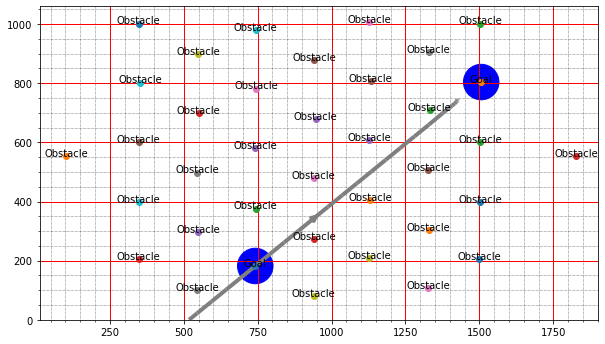

In [141]:
seek_points = np.array([[start_x,start_y]]) 

fig, ax = plt.subplots(figsize=(10, 10))
ax.set_aspect('equal')

deltX, deltY = add_goal( X, Y, s, r, (start_x, start_y) )
plot_graph( X, Y, deltX, deltY, 'Goal', fig, ax, ( start_x, start_y ), goalR, 0, 'b' )

deltX, deltY = add_goal( X, Y, s, r, (goal_x, goal_y) )
plot_graph( X, Y, deltX, deltY, 'Goal', fig, ax, ( goal_x, goal_y ), goalR, 0, 'b' )

for ob in obsPoints:
    deltX, deltY, loc, r = add_obstacle( X, Y, deltX, deltY, ( goal_x, goal_y ) )
    plot_graph( X, Y, deltX, deltY, 'Obstacle', fig, ax, ob, r, 0, 'm' )

print( deltX, deltY )
ax.streamplot(X,Y,deltX,deltY, start_points=seek_points,linewidth=4, cmap='autu')
plt.show()